In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import urllib
import instaloader
from instaloader import *
from skimage import io
import os
from PIL import *
import requests
from io import BytesIO
import PIL.ImageStat
import pickle 
import Algorithmia
import datetime 
import pandas as pd
import torch 
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression


In [12]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pickle.load( open( "save_frame2.p", "rb" ) )
y = data['label']
del data['label']
del data['keys']
train_x, test_x, train_y, test_y = train_test_split(data, y, test_size=0.25, random_state=42)

In [ ]:
len(data.columns)

In [ ]:
train = data[:2800]

In [4]:
class Dataset(Dataset):
    """CIFAR-10 image dataset."""
    def __init__(self, X, y, transformations=None):
        self.len = len(X)           
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [70]:
class FeedForwardNN(nn.Module):
    """ 
        (1) Use self.fc1 as the variable name for your first fully connected layer
        (2) Use self.fc2 as the variable name for your second fully connected layer
    """
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(39, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = self.dropout(x)
        return x

    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation 
    """
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()

In [41]:
class ConvolutionalNN(nn.Module):
    """ 
        (1) Use self.conv1 as the variable name for your first convolutional layer
        (2) Use self.pool as the variable name for your pooling layer
        (3) User self.conv2 as the variable name for your second convolutional layer
        (4) Use self.fc1 as the variable name for your first fully connected layer
        (5) Use self.fc2 as the variable name for your second fully connected layer
        (6) Use self.fc3 as the variable name for your third fully connected layer
    """
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 7, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(7, 16, 3)
        self.fc1 = nn.Linear(16*13*13, 130)
        self.fc2 = nn.Linear(130, 72)
        self.fc3 = nn.Linear(72, 10)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = x.view(-1, 16*13*13)
        print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation 
    """
    def get_conv1_params(self):
        return self.conv1.__repr__()
    
    def get_pool_params(self):
        return self.pool.__repr__()

    def get_conv2_params(self):
        return self.conv2.__repr__()
    
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()
    
    def get_fc3_params(self):
        return self.fc3.__repr__()

In [71]:
def run_experiment(neural_network, train_loader, test_loader, loss_function, optimizer, lr):
    """
    Runs experiment on the model neural network given a train and test data loader, loss function and optimizer.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        train_loader (DataLoader),
        test_loader (DataLoader),
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (optim.SGD)
    Returns:
        tuple: First position, testing accuracy.
               Second position, training accuracy.
               Third position, training loss.

               For example, if you find that
                            testing accuracy = 0.76,
                            training accuracy = 0.24
                            training loss = 0.56

               This function should return (0.76, 0.24, 0.56)
    """
    tr_points = []
    te_points = []
    loss_points = []
    for epoch in range(500):
        if epoch % 50 == 0:
            #lr = lr * (0.1 ** (epoch // 30))
            #optimizer = optim.Adam(model.parameters(), lr=0.002)
            print(epoch)
        running_loss = 0.0
        k = 0
        for i,data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            model = neural_network
            criterion = loss_function
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            k = k + 1
            
    
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            te_ac = correct / total
            #print(te_ac)
            te_points.append(te_ac)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            tr_ac = correct / total
            #print(tr_ac)
            tr_points.append(tr_ac)
        loss_points.append(running_loss / k)
    #return tr_ac, te_ac, running_loss
    return tr_points, te_points, loss_points  

In [72]:
#y = data['label']
#del data['label']
#del data['keys']
#train_x, test_x, train_y, test_y = train_test_split(data, y, test_size=0.2, random_state=42)
# train_x = data[:2800]
# train_y = y[:2800]
# test_x = data[2800:]
# test_y = y[2800:]
data_tr = Dataset(train_x.values, train_y.values)
data_te = Dataset(test_x.values, test_y.values)
train_loader = torch.utils.data.DataLoader(dataset=data_tr, 
                                           batch_size=16, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_te, 
                                          batch_size= 16, 
                                          shuffle=False)
model = FeedForwardNN()
#model = ConvolutionalNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

0


/Users/jamaalhay/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


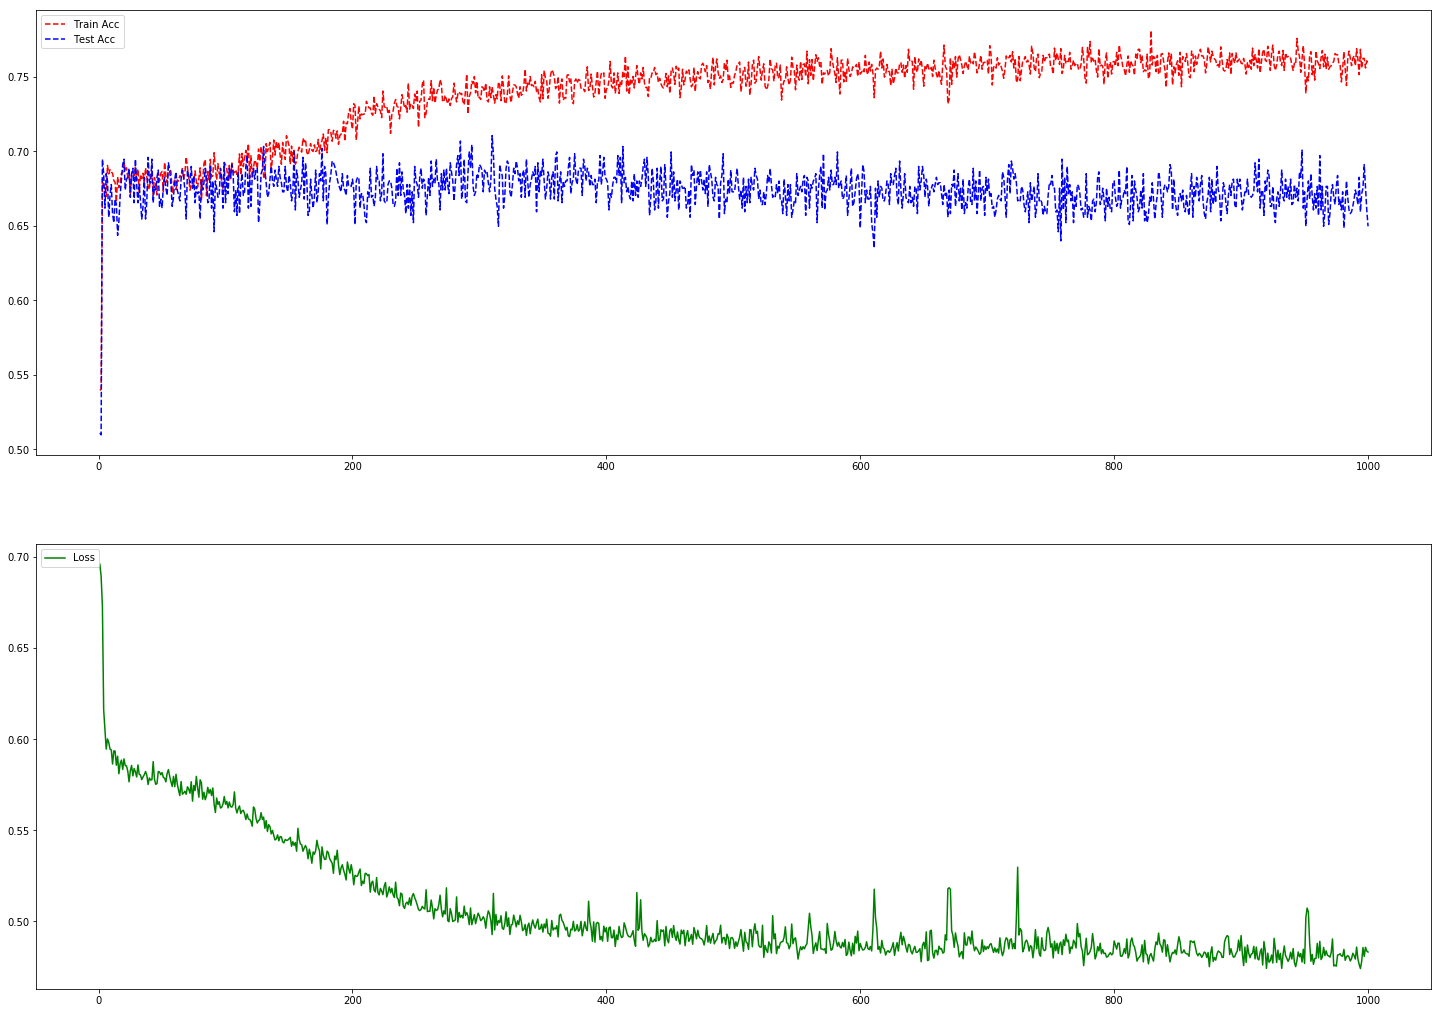

In [69]:
acc1_norm, acc2_norm, losst_norm = run_experiment(model, train_loader, test_loader, loss, optimizer, 0.002)
x = range(1,501) 
plt.figure(1)
ax = plt.subplot(211)
ax.plot(x, acc1_norm, 'r--', label = "Train Acc")
ax.plot(x, acc2_norm, 'b--', label = "Test Acc")
ax.legend(loc = 2)
ax2 = plt.subplot(212)
plt.plot(x, losst_norm, 'g', label = "Loss")
ax2.legend(loc = 2)
plt.rcParams["figure.figsize"] = [25,18]
plt.show()

In [8]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_x, train_y)
score = logisticRegr.score(test_x, test_y)
print(score)

0.7201946472019465


/Users/jamaalhay/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
clf = svm.SVC()
clf.fit(train_x, train_y) 
score = clf.score(test_x, test_y)
print(score)

/Users/jamaalhay/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7238442822384428


In [95]:
clf = RandomForestClassifier(n_estimators=1000,max_depth=8, random_state=0, criterion = 'entropy')
clf.fit(train_x, train_y) 
score = clf.score(test_x, test_y)
print(score)
print(clf.feature_importances_)

0.7335766423357665
[0.02071093 0.00293412 0.02975348 0.02977681 0.0283979  0.03007354
 0.03149078 0.03301806 0.03009918 0.03074529 0.03054053 0.02801426
 0.02756069 0.03061649 0.02957936 0.00288059 0.00327977 0.00396749
 0.00495357 0.00311848 0.00333361 0.00265764 0.00243624 0.00177012
 0.00297869 0.00739949 0.00428249 0.0069515  0.03293019 0.00926771
 0.0180797  0.01297945 0.01178713 0.13008011 0.09840051 0.01019858
 0.01120008 0.02754801 0.17420745]


In [96]:
data = pickle.load( open( "save_frame2.p", "rb" ) )
print(data.columns)

Index(['keys', 'detection', 'blur', 'brightness', 'col1Num1', 'col1Num2',
       'col1Num3', 'col1P', 'col2Num1', 'col2Num2', 'col2Num3', 'col2P',
       'col3Num1', 'col3Num2', 'col3Num3', 'col3P', '90s', 'Bohemian',
       'Business', 'Casual', 'Denim', 'Eclectic', 'Elegant', 'Outdoor',
       'Rocker', 'Romantic', 'Sexy', 'Vintage', 'smile', 'capLen', 'capMen',
       'hour', 'numHash', 'weekday', 'label', 'vec1', 'vec2', 'vec3', 'vec4',
       'vec5', 'vec6'],
      dtype='object')
